In [ ]:
# !pip install tensorflow_datasets

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ----------------- ---------------------- 2.4/5.3 MB 12.2 MB/s eta 0:00:01
   ----------------------------------- ---- 4.7/5.3 MB 11.9 MB/s eta 0:00:01
   ---------------------------------------- 5.3/5.3 MB 11.5 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21544 sha256=ccd0137856c941d442eedaa4470a1e340b08af7fbaa95b96159783d683397776
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\e7\e6\28\864bdfee5339dbd6ddcb5a186286a8e217648ec198bdf0097d
Successfully built promise


In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
DATA_DIR = 'dataset/'

(train_ds, valid_ds),info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                      shuffle_files=True,
                                      as_supervised=True,
                                      with_info=True,
                                      data_dir=DATA_DIR)

print(train_ds)
print(valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
print(info)

# 메타 정보를 할당받은 info변수를 출력하면, 데이터셋에 대한 기본정보를 보여준다.
# 앞서우리는 EUROSAT 데이터셋의 2가지 유형 중에서 JPEG이미지로 인코딩한 RGB데이터셋을 다운로드 한 상태다.

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='dataset\\eurosat\\rgb\\2.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('imag

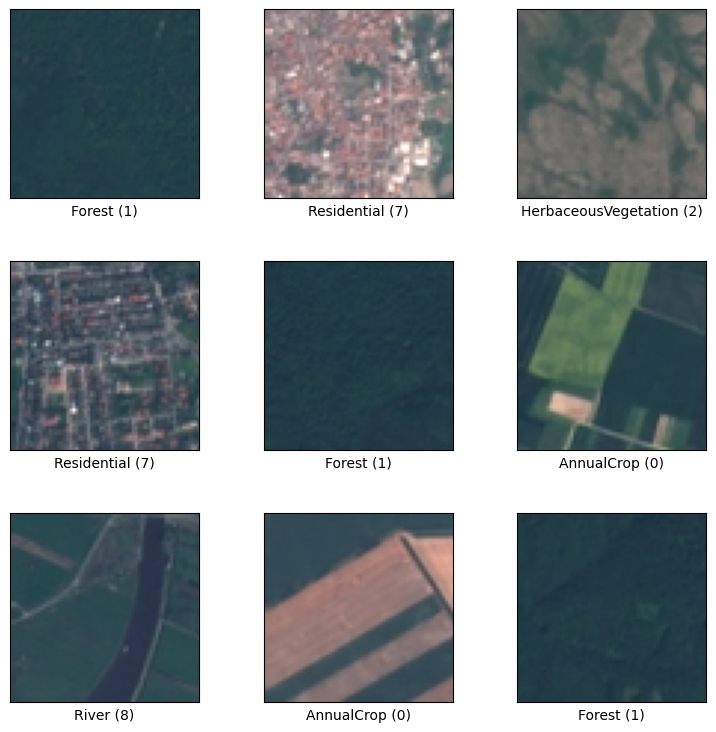

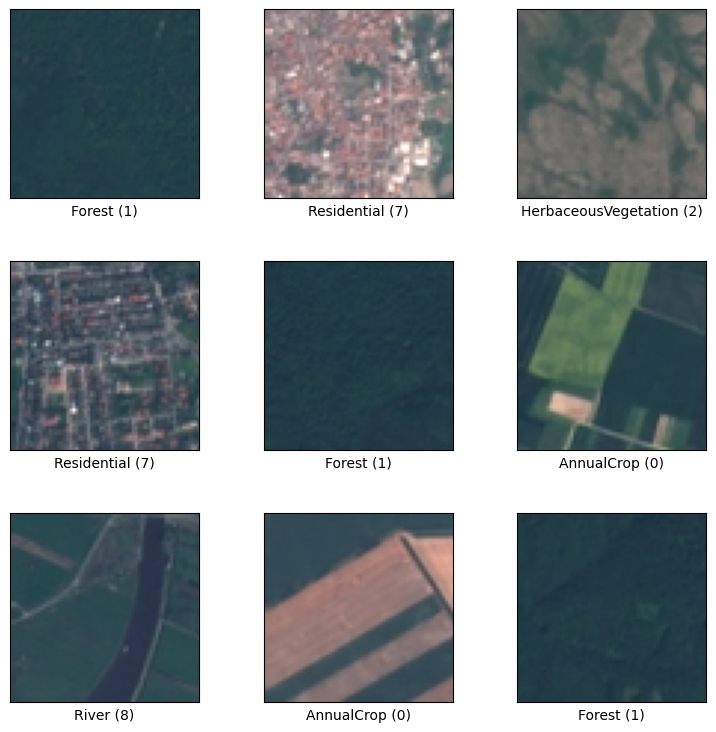

In [ ]:
tfds.show_examples(train_ds, info)

# 샘플이미지를 메타정보인 분류레이블과 함께 화면에 출력한다.
# show_examples 함수를 사용하는 예제다.

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

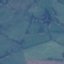
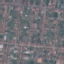
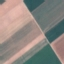
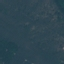
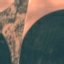
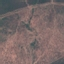
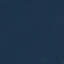
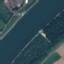
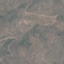
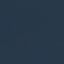

In [ ]:
tfds.as_dataframe(valid_ds.take(10), info)

#이번에는 as_dataframe함수를 사용하여 샘플이미지10개를 화면에 표시하는 예제다

In [ ]:
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

# 토지 이용분류에 해당하는 정답클래스 개수는 10개다
# 앞의 실행결과를 보면 클래스0은 경작지(annual_crop),클래스 9는 바다/호수(sealake)를 나타낸다.

10


In [ ]:
print(info.features['label'].int2str(6))

# 클래스를 나타내는 숫자레이블을 메타데이터의 문자열로 변환할수있다. 메타데이터의 features 값중에서 
# label에 해당하는 메타정보에 int2str()메소드를 적용한다.
# 클래스6은 영구작물(permanent crop)을 나타내는것을 확인할수있다

PermanentCrop


In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32)/255.
    return image,label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
def build_model():

    model = tf.keras.Sequential([

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
           
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

model = build_model()


# 배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛을 2개 연결하고,
# dense레이어와 dropout으로 구성된 최종분류기를 갖는 딥러닝모델을 sequential API로 생성한다

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=50)

#예측클래스가 10개인 다중분류문제에 맞게 손실함수와 평가지표를 설정하고, 모델을 50데폭 훈련시킨다.

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.3688 - loss: 1.9024 - val_accuracy: 0.4541 - val_loss: 1.6725
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.5698 - loss: 1.2311 - val_accuracy: 0.6983 - val_loss: 0.8814
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 47s 140ms/step - accuracy: 0.6420 - loss: 1.0325 - val_accuracy: 0.7715 - val_loss: 0.7311
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 51s 150ms/step - accuracy: 0.6965 - loss: 0.8852 - val_accuracy: 0.7767 - val_loss: 0.6603
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 50s 147ms/step - accuracy: 0.7271 - loss: 0.8119 - val_accuracy: 0.7767 - val_loss: 0.6580
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.7579 - loss: 0.7272 - val_accuracy: 0.7826 - val_loss: 0.6019
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.7808 - loss: 0.6644 - val_accuracy: 0.8131 - val_loss: 0.5813
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.8027 - loss: 0

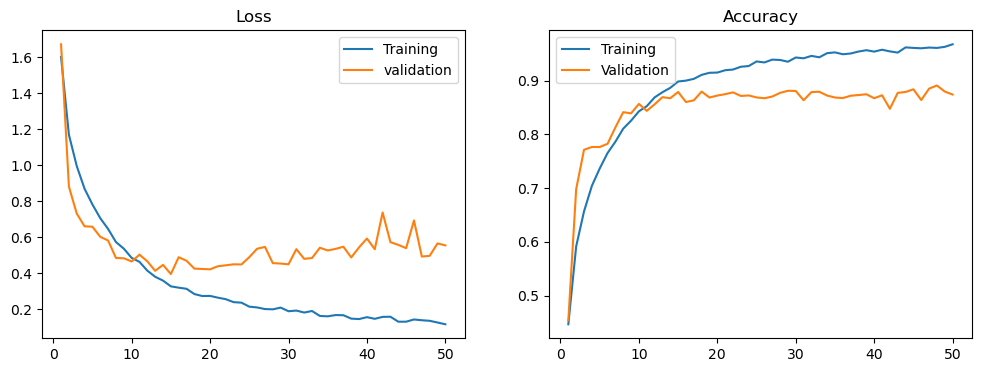

In [ ]:
def plot_loss_acc(history, epoch):

    loss,val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1,2,figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()


plot_loss_acc(history,50)

# 모델은 10 에폭 까지는 빠른속도로 훈련이 진행되면서 손실함수가 급격하게 감소한다.
# 하지만 그 이후로는 검증셋에 대한 손실함수가 더이상 줄어들지 않으면서 과대적합 경향을 나타낸다.


In [ ]:
# # 데이터 증강(Data Augmentation)

# 앞서 배운 과대적합을 해소하는 기법인 배치 정규화, 드롭아웃등을 적용했음에도 과대적합이 발생하였다.
# 이미지 분류문제에서 과대적합을 해소하고, 모델의 일반화된 robust한 성능을 확보하는 기법으로
# 데이터 증강(data augmentation)기법을 소개한다.
# 이미지 데이터에 여러가지 변형을 주어서 훈련데이터의 다양성을 확보하는 방법으로,
# 모델이 새로운 데이터에 대한 예측령을 강화하도록 갖는 개념이다.


Text(0.5, 1.0, 'AnnualCrop')

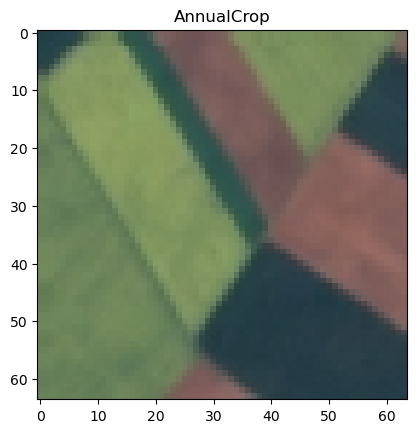

In [ ]:
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label))


In [ ]:
def plot_augmentation(original,augmented):

    fig,axes = plt.subplots(1,2,figsize=(12,4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()


# 샘플이미지에 변화를 주기 전과 후의 이미지를 비교할수있는 시각화 함수를 정의한다

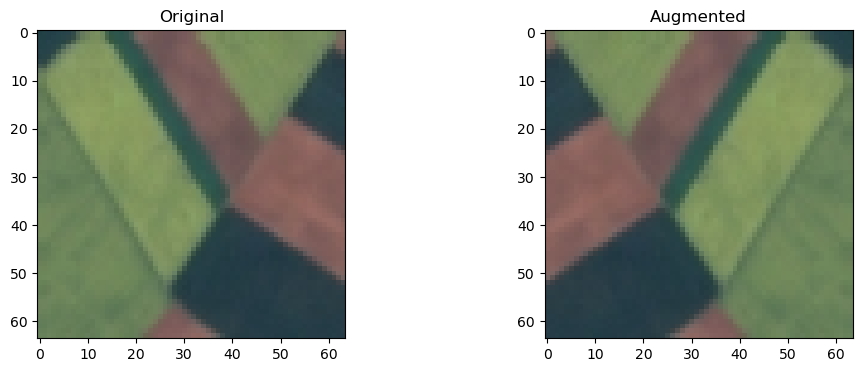

In [ ]:
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

# tf.image모듈의 flip_left_right함수를 사용하여 이미지를 좌우방향으로 뒤집는 방법이다.

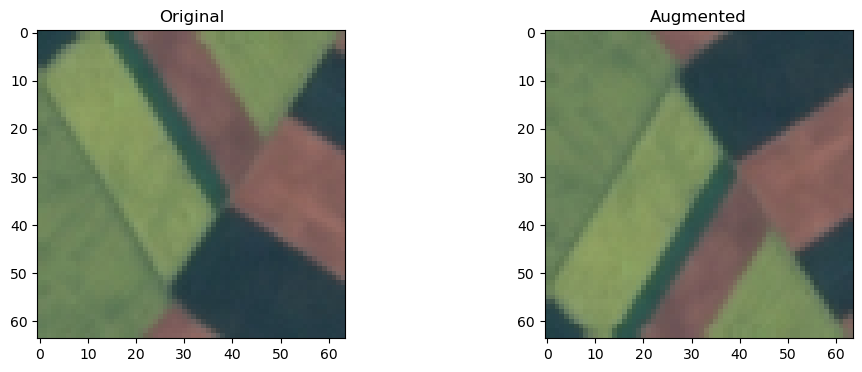

In [28]:
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

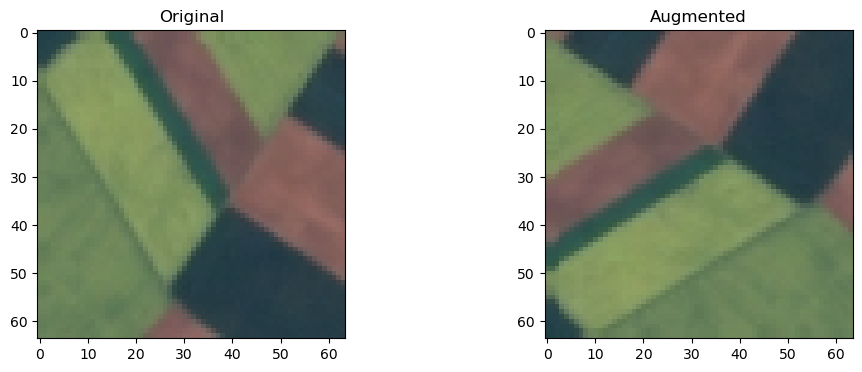

In [29]:
rotate90 = tf.image.rot90(image)
plot_augmentation(image,rotate90)

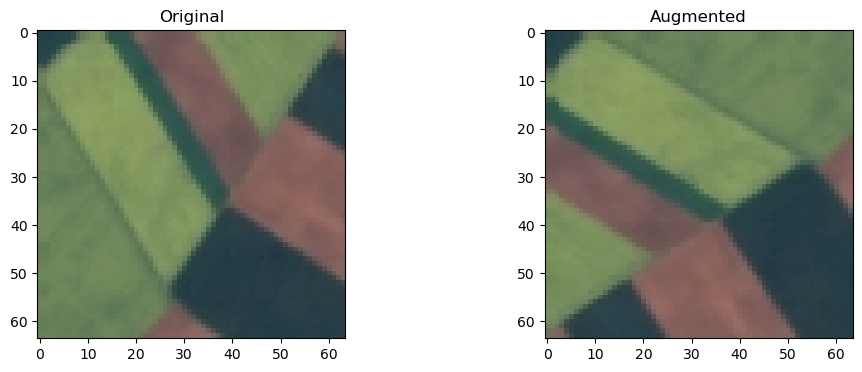

In [30]:
transpose = tf.image.transpose(image)
plot_augmentation(image,transpose)

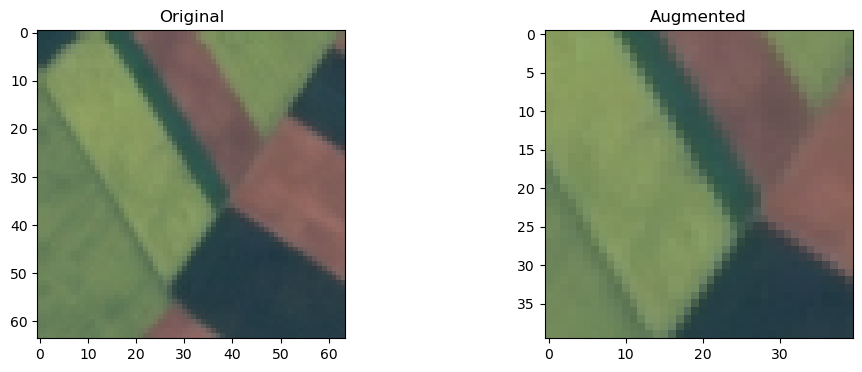

In [ ]:
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1) 

# 이미지의 중심에서 일정부분을 잘라내는 방법을 구현한다

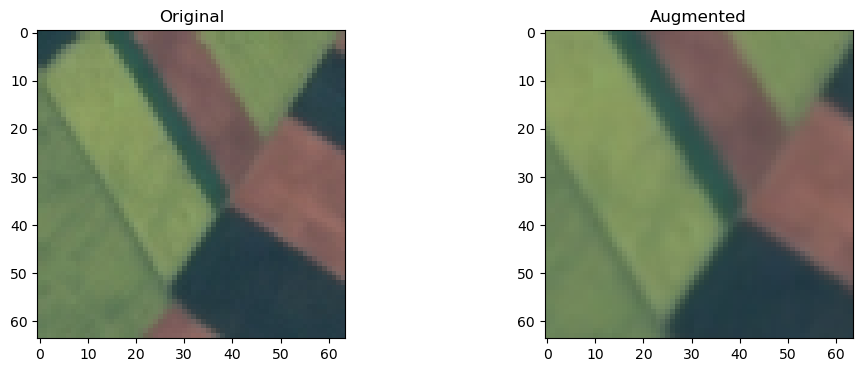

In [ ]:
img = tf.image.resize_with_pad(image, 64+20, 64+20)
crop2 = tf.image.random_crop(img, size=[64,64,3])
plot_augmentation(image, crop2)

# 먼저 resize_with_crop_or_pad 함수를 사용하여, 원본이미지의 크기를 키운다.
# 여기에 random_crop함수를 사용하고 이미지를 원본크기와 같게 자르면 
# 원본이미지가 상하좌우 랜덤한 방향으로 시프트(shift) 이동한다

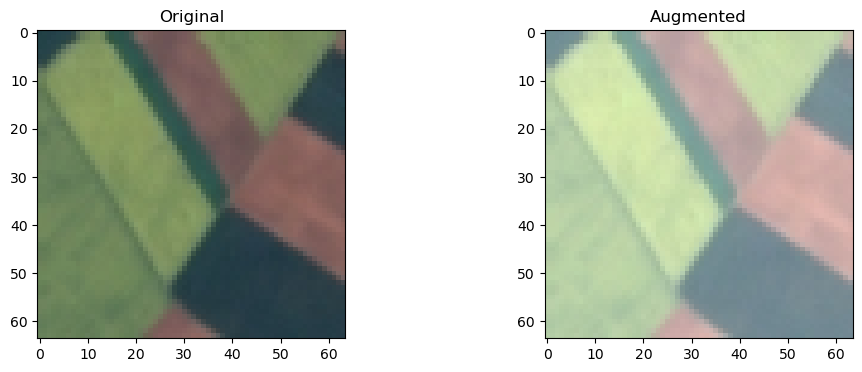

In [ ]:
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

# 밝기 변경

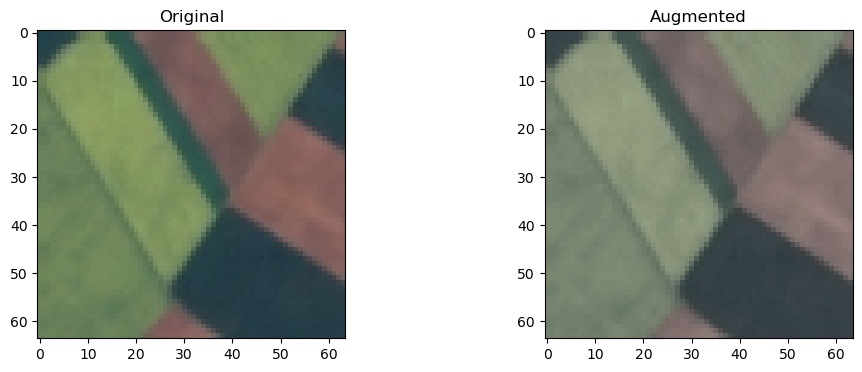

In [ ]:
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image,saturation)

# 채도 변경

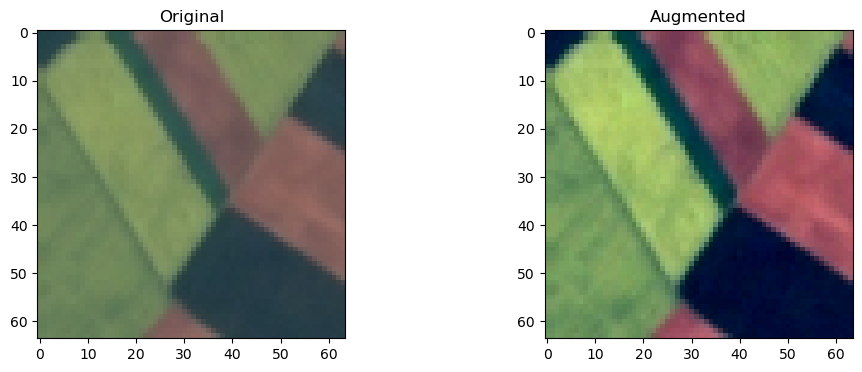

In [ ]:
contrast = tf.image.adjust_contrast(image,contrast_factor=2)
plot_augmentation(image,contrast)

# 이미지 대비 조정

In [39]:
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_crop(image, size=[64,64,3])

    image = tf.cast(image, tf.float32) / 255.

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [40]:
aug_model = build_model()

aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

aug_history = aug_model.fit(train_aug,
                        validation_data=valid_aug,
                        epochs=50)

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.2260 - loss: 2.2910 - val_accuracy: 0.3472 - val_loss: 1.7281
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.3579 - loss: 1.7062 - val_accuracy: 0.4856 - val_loss: 1.3161
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.4381 - loss: 1.4801 - val_accuracy: 0.5828 - val_loss: 1.1955
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 46s 137ms/step - accuracy: 0.4750 - loss: 1.3714 - val_accuracy: 0.5522 - val_loss: 1.2588
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 45s 132ms/step - accuracy: 0.5198 - loss: 1.2940 - val_accuracy: 0.6296 - val_loss: 1.0567
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 45s 132ms/step - accuracy: 0.5463 - loss: 1.2157 - val_accuracy: 0.6509 - val_loss: 1.0256
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.5533 - loss: 1.2083 - val_accuracy: 0.6635 - val_loss: 0.9550
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 47s 138ms/step - accuracy: 0.5868 - loss: 1

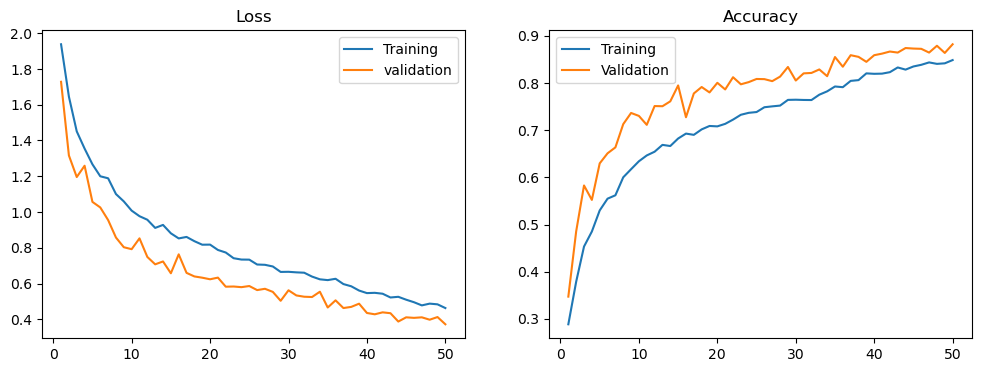

In [41]:
plot_loss_acc(aug_history,50)

In [ ]:
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                              weights = 'imagenet',
                              input_shape=[64,64,3])

pre_trained_base.trainable=False

# from tensorflow.python.keras.utils.vis_utils import plot_model
# plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [44]:
def build_transfer_classifier():

    model = tf.keras.Sequential([

        pre_trained_base,

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model


tc_model = build_transfer_classifier()
tc_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,622,410 (93.93 MB)

 Trainable params: 1,057,610 (4.03 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [46]:
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

tc_history = tc_model.fit(train_aug,
                      validation_data=valid_data,
                      epochs=50)

Epoch 1/50


338/338 ━━━━━━━━━━━━━━━━━━━━ 134s 377ms/step - accuracy: 0.5713 - loss: 1.3214 - val_accuracy: 0.8202 - val_loss: 0.5709
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 144s 425ms/step - accuracy: 0.7579 - loss: 0.7496 - val_accuracy: 0.8341 - val_loss: 0.4967
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 139s 410ms/step - accuracy: 0.7862 - loss: 0.6706 - val_accuracy: 0.8441 - val_loss: 0.4658
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 124s 366ms/step - accuracy: 0.8082 - loss: 0.6036 - val_accuracy: 0.8483 - val_loss: 0.4434
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 119s 351ms/step - accuracy: 0.8094 - loss: 0.5839 - val_accuracy: 0.8565 - val_loss: 0.4318
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 118s 348ms/step - accuracy: 0.8239 - loss: 0.5506 - val_accuracy: 0.8513 - val_loss: 0.4442
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 113s 335ms/step - accuracy: 0.8312 - loss: 0.5207 - val_accuracy: 0.8631 - val_loss: 0.4089
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 117s 345ms/step - accuracy: 0.8349 - loss: 0.50

KeyboardInterrupt: 

In [ ]:
plot_loss_acc(tc_history, 50)